In [1]:
import pandas as pd
import numpy as np
import random

# File operations
from copy import deepcopy
import glob
import os
from pathlib import Path

# AHBA
import abagen

# Neuromaps
import neuromaps
from neuromaps.parcellate import Parcellater
from neuromaps import datasets, images, nulls, resampling, stats
from nibabel import freesurfer as fs
import nibabel as nib
from neuromaps.datasets import fetch_annotation, fetch_fslr
from enigmatoolbox.datasets import load_sc, load_fc

# Stats
from scipy.stats import spearmanr, wilcoxon, mannwhitneyu
import statsmodels.stats.multitest

# Set seed to 127
random.seed(127)

%load_ext rpy2.ipython

In [2]:
%%R 

suppressPackageStartupMessages({
    library(cowplot)
    library(ggseg)
    library(glue)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

In [3]:
# Read in brain region lookup table
brain_region_info = pd.read_csv("../data/Brain_Region_Info.csv")

#### GROUP-AVERAGED FUNCTIONAL CONNECTOME FROM ENIGMA #### 
# Load cortico-cortical functional connectivity data
fc_ctx, fc_ctx_labels, _, _ = load_fc(parcellation='aparc')

# Load cortico-cortical functional connectivity data
fc_ctx, fc_ctx_labels, fc_subctx_to_ctx, fc_subctx_labels = load_fc(parcellation='aparc')

# Read in preprocessed Pearson-based functional connectivity data from ENIGMA
HCP_avg_Pearson_FC = (pd.DataFrame(fc_ctx, columns=fc_ctx_labels)
                      .assign(Brain_Region_From = fc_ctx_labels)
                      .melt(id_vars=["Brain_Region_From"], 
                             var_name="Brain_Region_To", 
                             value_name="Mean_Pearson_R")
                      .assign(Base_Region_From = lambda x: x['Brain_Region_From'].str.replace("L_", "").str.replace("R_", ""),
                              Base_Region_To = lambda x: x['Brain_Region_To'].str.replace("L_", "").str.replace("R_", ""),
                              Hemi_From = lambda x: np.where(x['Brain_Region_From'].str.startswith("L_"), "Left", "Right"),
                              Hemi_To = lambda x: np.where(x['Brain_Region_To'].str.startswith("L_"), "Left", "Right"))
)

pearson_homotopic_res_mean = (HCP_avg_Pearson_FC
                              .query("Base_Region_From == Base_Region_To")
                              .groupby(["Base_Region_From"])['Mean_Pearson_R']
                              .mean() 
                              .reset_index()
                              .rename(columns={"Base_Region_From": "Base_Region"})
                              )

subctx_to_ctx_FC = (pd.DataFrame(fc_subctx_to_ctx, columns=fc_ctx_labels)
                          .assign(Brain_Region_From = fc_subctx_labels)
                          .melt(id_vars=["Brain_Region_From"],
                            var_name="Brain_Region_To", 
                            value_name="Mean_Pearson_R")
                            .assign(Hemisphere_From = lambda x: x["Brain_Region_From"].str[0].map({"L": "Left", "R": "Right"}),
                              Hemisphere_To = lambda x: x["Brain_Region_To"].str[0].map({"L": "Left", "R": "Right"}))
                            .assign(Base_Region_From = lambda x: x["Brain_Region_From"].str[1:],
                                    Base_Region_To = lambda x: x.Brain_Region_To.str.replace("L_", "").str.replace("R_", ""))
                            [['Base_Region_From', 'Base_Region_To', 'Mean_Pearson_R']]
                            .rename(columns={"Mean_Pearson_R": "FC_with_subctx",
                                             "Base_Region_From": "Subcortical_Region",
                                             "Base_Region_To": "Base_Region"})
                     # Remove first letter from the region names

)

HoFC_with_subctx_connectivity = (pearson_homotopic_res_mean
    .rename(columns={"Base_Region": "Base_Region",
                     "Mean_Pearson_R": "HoFC"})
    .merge(subctx_to_ctx_FC, on="Base_Region")
    .groupby(['Base_Region', 'Subcortical_Region'])[['HoFC', 'FC_with_subctx']]
    .mean()
    .reset_index()
)

HoFC_with_subctx_connectivity.head()

,Base_Region,Subcortical_Region,HoFC,FC_with_subctx
0,bankssts,accumb,0.31467,0.016905
1,bankssts,amyg,0.31467,0.098062
2,bankssts,caud,0.31467,0.103207
3,bankssts,hippo,0.31467,0.152820
4,bankssts,pal,0.31467,0.034594


In [4]:
# Load CTIP2 and Satb2 gene expression data if available
if os.path.isfile('../data/Pyramidal_neuron_CTIP2_Satb2_expression_ctx.csv'):
    pyramidal_neuron_key_gene_expression_ctx = pd.read_csv('../data/Pyramidal_neuron_CTIP2_Satb2_expression_ctx.csv')

else:
    abagen.fetch_microarray(donors='all', verbose=1)

    atlas = abagen.fetch_desikan_killiany()
    atlas_info = pd.read_csv(atlas['info'])
    expression = abagen.get_expression_data(atlas['image'], atlas['info'])

    CTIP2_expression = expression['BCL11B']
    Satb2_expression = expression['SATB2']

    pyramidal_neuron_key_gene_expression_ctx = (pd.DataFrame({'CTIP2': CTIP2_expression.values, 
                                                              'Satb2': Satb2_expression.values, 
                                                'region': atlas_info.label, 'hemisphere': atlas_info.hemisphere,
                                                'structure': atlas_info.structure})
                                                .query("structure=='cortex'")
                                                .groupby(['region', 'hemisphere'])[['CTIP2', 'Satb2']]
                                                .mean()
                                                .reset_index()
                                                .rename(columns={'region': 'Base_Region'})
    )

    # Write to csv
    pyramidal_neuron_key_gene_expression_ctx.to_csv('../data/Pyramidal_neuron_CTIP2_Satb2_expression_ctx.csv', index=False)

# Take the mean between the left and right hemisphere
pyramidal_neuron_key_gene_expression_ctx_base = (pyramidal_neuron_key_gene_expression_ctx
                                                 .groupby(['Base_Region'])[['CTIP2', 'Satb2']]
                                                    .mean()
                                                    .reset_index()
)

gene_HoFC_merged = pearson_homotopic_res_mean.merge(pyramidal_neuron_key_gene_expression_ctx_base, on="Base_Region")

CTIP2_rho, CTIP2_p = spearmanr(gene_HoFC_merged['Mean_Pearson_R'], gene_HoFC_merged['CTIP2'])
Satb2_rho, Satb2_p = spearmanr(gene_HoFC_merged['Mean_Pearson_R'], gene_HoFC_merged['Satb2'])

print(f"CTIP2: rho={CTIP2_rho:.2f}, p={CTIP2_p:.2e}")
print(f"Satb2: rho={Satb2_rho:.2f}, p={Satb2_p:.2e}")


CTIP2: rho=-0.28, p=1.13e-01
Satb2: rho=0.49, p=2.95e-03


Joining with `by = join_by(label)`
Joining with `by = join_by(label)`
Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi', 'geometry'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi', 'geometry'


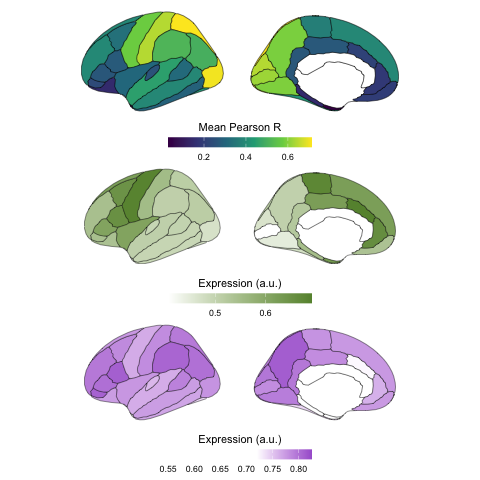

In [5]:
%%R -i pyramidal_neuron_key_gene_expression_ctx_base,pearson_homotopic_res_mean

legendwidth <- 2

Pearson_HoFC_brain <- pearson_homotopic_res_mean %>%
  ungroup() %>%
  mutate(label = glue("lh_{Base_Region}")) %>%
  left_join(., as_tibble(dk)) %>%
  ggseg(atlas = dk, mapping = aes(fill = Mean_Pearson_R),
        position = "stacked", colour = "black", hemisphere="left",
        linewidth=0.25) +
  theme_void() +
  labs(fill = "Mean Pearson R") +
  guides(fill = guide_colorbar(title.position="top", title.hjust=0.5)) +
  theme(plot.title = element_text(face='bold', size=14, hjust=0.5),
            legend.key.width  = unit(legendwidth, "lines"),
            legend.key.height  = unit(0.7, "lines"),
            legend.position = "bottom") +
  scale_fill_viridis_c(na.value = "white")

CTIP2_brain <- pyramidal_neuron_key_gene_expression_ctx_base %>%
      mutate(label = glue("lh_{Base_Region}")) %>%
      left_join(., as_tibble(dk)) %>%
      filter(hemi=='left') %>%
      ggplot() +
      geom_brain(atlas = dk, mapping = aes(fill = CTIP2),
                 hemi = "left", color='black') +
      theme_void() +
      labs(fill = "Expression (a.u.)") +
      guides(fill = guide_colorbar(title.position="top", title.hjust=0.5)) +
      theme(plot.title = element_text(face='bold', size=14, hjust=0.5),
            legend.key.width  = unit(legendwidth, "lines"),
            legend.key.height  = unit(0.7, "lines"),
            legend.position = "bottom") +
      scale_fill_gradient(low="white", high="#67913c", na.value = "white")

Satb2_brain <- pyramidal_neuron_key_gene_expression_ctx_base %>%
      mutate(label = glue("lh_{Base_Region}")) %>%
      left_join(., as_tibble(dk)) %>%
      filter(hemi=='left') %>%
      ggplot() +
      geom_brain(atlas = dk, mapping = aes(fill = Satb2),
                 hemi = "left", color='black') +
      theme_void() +
      labs(fill = "Expression (a.u.)") +
      guides(fill = guide_colorbar(title.position="top", title.hjust=0.5)) +
      theme(plot.title = element_text(face='bold', size=14, hjust=0.5),
            legend.key.width  = unit(legendwidth, "lines"),
            legend.key.height  = unit(0.7, "lines"),
            legend.position = "bottom") +
      scale_fill_gradientn(
            colours = c("white", "white", "#a864d2"),
            values = scales::rescale(c(0.55, 0.72, 0.825)),
            limits = c(0.55, 0.825),
            na.value = "white"
            )

wrap_plots(list(Pearson_HoFC_brain, CTIP2_brain, Satb2_brain), ncol=1)
# ggsave("../plots/brain_maps_corrs/Layer5_Neuron_Gene_Expression_brainmaps.svg", width=4, height=6, units='in', dpi=300)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'



ℹ Please use `after_stat(r.label)` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 

ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 



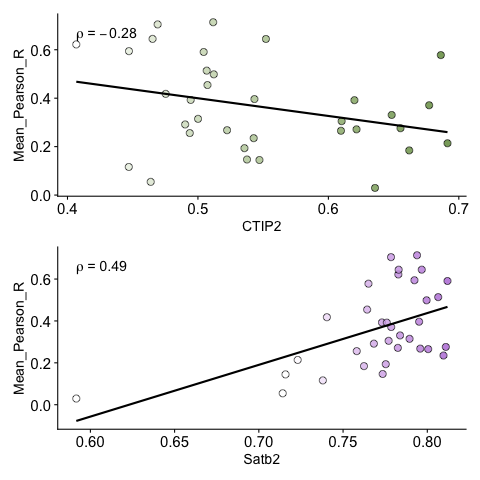

In [6]:
%%R -i gene_HoFC_merged

# CTIP2 scatter plot
CTIP2_scatter <- gene_HoFC_merged %>% 
      ggplot(data=., mapping=aes(x=CTIP2, y=Mean_Pearson_R, fill=CTIP2)) +
      geom_point(shape=21, color='black', size=3, alpha=0.8) +
      ggpubr::stat_cor(method="spearman", cor.coef.name="rho", size=5, aes(label = ..r.label..)) +
      theme(legend.position='none') +
      geom_smooth(method='lm', se=FALSE, color='black') +
      scale_fill_gradient(low="white", high="#67913c") +
      theme(strip.background = element_blank(),
            strip.text = element_text(face='bold', size=16),
            axis.text = element_text(size=15))

# Satb2 scatter plot
Satb2_scatter <- gene_HoFC_merged %>%
      ggplot(data=., mapping=aes(x=Satb2, y=Mean_Pearson_R, fill=Satb2)) +
      geom_point(shape=21, color='black', size=3, alpha=0.8) +
      ggpubr::stat_cor(method="spearman", cor.coef.name="rho", size=5, aes(label = ..r.label..)) +
      theme(legend.position='none') +
      geom_smooth(method='lm', se=FALSE, color='black') +
            scale_fill_gradientn(
            colours = c("white", "white", "#a864d2"),
            values = scales::rescale(c(0.55, 0.72, 0.825)),
            limits = c(0.55, 0.825),
            na.value = "white"
            ) +
      theme(strip.background = element_blank(),
            strip.text = element_text(face='bold', size=16),
            axis.text = element_text(size=15))

wrap_plots(list(CTIP2_scatter, Satb2_scatter), ncol=1)
# ggsave("../plots/brain_maps_corrs/Layer5_Neuron_Gene_Expression_scatters.svg", width=3, height=6, units='in', dpi=300)

In [7]:
# Define the left- and right-hemisphere Desikan-Killiany (DK) atlas
lh_dk = "../data/fsaverage/lh.aparc.annot"
rh_dk = "../data/fsaverage/rh.aparc.annot"

# Convert the DK atlas to gifti format
# dk_gifti = neuromaps.images.annot_to_gifti((lh_dk, rh_dk), background=None)
dk_gifti = neuromaps.images.annot_to_gifti(lh_dk, background=None)
dk_gifti = neuromaps.images.relabel_gifti(dk_gifti)

# Fit a Parcellator object
dk_parc = Parcellater(dk_gifti, 'fsLR', resampling_target='parcellation', hemi='L')

# Satb2 first
rng = np.random.default_rng(seed=127)  # for reproducibility
SATB2_measure = gene_HoFC_merged['Satb2'].values
CTIP2_measure = gene_HoFC_merged['CTIP2'].values
HoFC_measure = gene_HoFC_merged['Mean_Pearson_R'].values

# Assume you are working with fsaverage and the Desikan-Killiany atlas
atlas = 'fsLR'

# Use SATB2 map to generate the nulls
spins_SATB2 = nulls.alexander_bloch(SATB2_measure, atlas=atlas, parcellation=dk_gifti, density='164k',
                              n_perm=10000, seed=127)
spins_CTIP2 = nulls.alexander_bloch(CTIP2_measure, atlas=atlas, parcellation=dk_gifti, density='164k',
                              n_perm=10000, seed=127)

# Step 4: Compare HoFC and SATB2 using the nulls
stat_SATB2, p_SATB2 = stats.compare_images(HoFC_measure, SATB2_measure, nulls=spins_SATB2, metric='spearmanr')
stat_CTIP2, p_CTIP2 = stats.compare_images(HoFC_measure, CTIP2_measure, nulls=spins_CTIP2, metric='spearmanr')

print(f"Observed SATB2 correlation: {stat_SATB2:.3f}, p-value: {p_SATB2:.4f}")
print(f"Observed CTIP2 correlation: {stat_CTIP2:.3f}, p-value: {p_CTIP2:.4f}")

Observed SATB2 correlation: 0.495, p-value: 0.0018
Observed CTIP2 correlation: -0.277, p-value: 0.2449


## HoFC vs thalamic connectivity

`geom_smooth()` using formula = 'y ~ x'



ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 



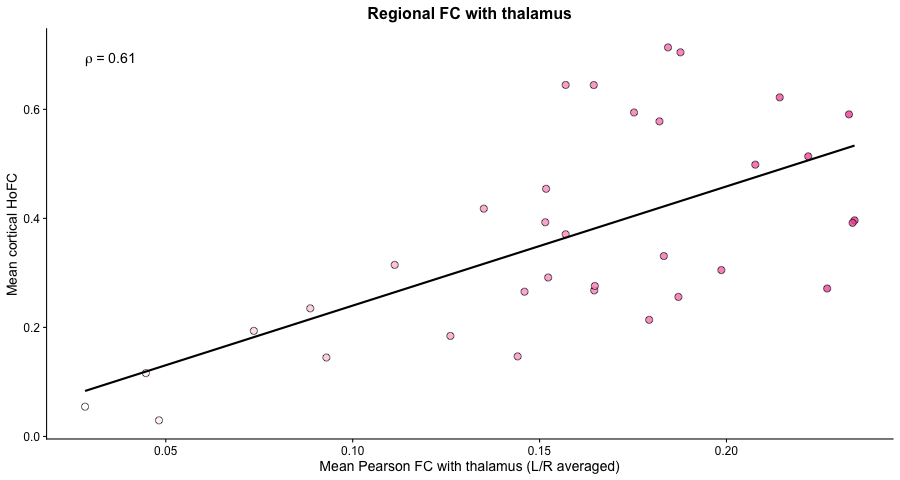

In [8]:
%%R -i HoFC_with_subctx_connectivity -w 900

HoFC_with_subctx_connectivity %>% 
    filter(Subcortical_Region == "thal") %>%
    ggplot(data=., mapping=aes(x=FC_with_subctx, y=HoFC, fill=FC_with_subctx)) +
    geom_point(shape=21, color='black', size=3, alpha=0.8) +
    ggtitle("Regional FC with thalamus") +
    geom_smooth(method="lm", se=FALSE, color='black') +
    ggpubr::stat_cor(method="spearman", cor.coef.name="rho", size=5, aes(label = ..r.label..)) +
    theme(legend.position='none')+
    ylab("Mean cortical HoFC") +
    scale_fill_gradient(low='white', high='#f357a7') +
    xlab("Mean Pearson FC with thalamus (L/R averaged)") +
    theme(strip.background = element_blank(),
          strip.text = element_text(face='bold', size=14),
          plot.title = element_text(hjust=0.5, face='bold', size=16))

# ggsave("../plots/brain_maps_corrs/Thalamus_FC_vs_HoFC_scatters.svg", width=3, height=3.25, units='in', dpi=300)

Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi', 'geometry'


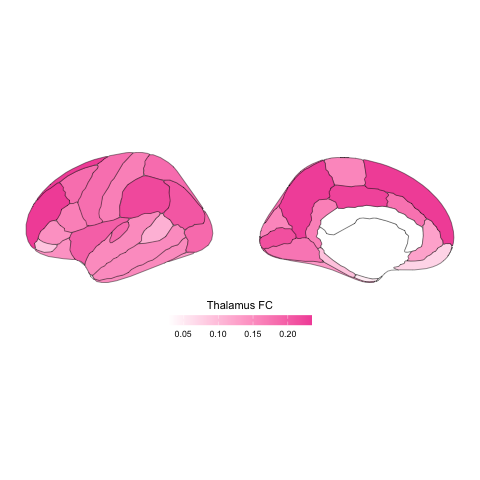

In [9]:
%%R -i HoFC_with_subctx_connectivity

legendwidth <- 2

HoFC_with_subctx_connectivity %>%
      filter(Subcortical_Region=='thal') %>%
      mutate(label = glue("lh_{Base_Region}")) %>%
      left_join(., as_tibble(dk)) %>%
      filter(hemi=='left') %>%
      ggplot() +
      geom_brain(atlas = dk, mapping = aes(fill = FC_with_subctx),
                 hemi = "left", color='black') +
      theme_void() +
      labs(fill = "Thalamus FC") +
      guides(fill = guide_colorbar(title.position="top", title.hjust=0.5)) +
      theme(plot.title = element_text(face='bold', size=14, hjust=0.5),
            legend.key.width  = unit(legendwidth, "lines"),
            legend.key.height  = unit(0.7, "lines"),
            legend.position = "bottom") +
      scale_fill_gradient(low='white', high='#f357a7', na.value = "white")
# ggsave("../plots/brain_maps_corrs/Thalamus_FC_vs_HoFC_brain.svg", width=4, height=3, units='in', dpi=300)

In [10]:
HoFC_with_thal_connectivity = HoFC_with_subctx_connectivity.query("Subcortical_Region=='thal'")
HoFC_with_thal_connectivity.head()

,Base_Region,Subcortical_Region,HoFC,FC_with_subctx
6,bankssts,thal,0.314670,0.111235
13,caudalanteriorcingulate,thal,0.213912,0.179315
20,caudalmiddlefrontal,thal,0.330858,0.183238
27,cuneus,thal,0.644840,0.156975
34,entorhinal,thal,0.029524,0.048178


In [11]:
# Spin test
rng = np.random.default_rng(seed=127)  # for reproducibility
thal_FC_measure = HoFC_with_thal_connectivity['FC_with_subctx'].values
HoFC_measure = HoFC_with_thal_connectivity['HoFC'].values

# Assume you are working with fsaverage and the Desikan-Killiany atlas
atlas = 'fsLR'

# Use DEF to generate the nulls
spins = nulls.alexander_bloch(thal_FC_measure, atlas=atlas, parcellation=dk_gifti, density='164k',
                              n_perm=10000, seed=127)

# Step 4: Compare ABC and DEF using the nulls
stat, p = stats.compare_images(HoFC_measure, thal_FC_measure, nulls=spins, metric='spearmanr')

print(f"Observed correlation: {stat:.3f}")
print(f"P-value (spin test): {p:.4f}")

Observed correlation: 0.608
P-value (spin test): 0.0007
